In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/analytics-vidhya-guided-hackathon/test_mPTIhGU/test.csv
/kaggle/input/analytics-vidhya-guided-hackathon/train_dPrl03o/train.csv


In [2]:
cd /kaggle/input/analytics-vidhya-guided-hackathon/

/kaggle/input/analytics-vidhya-guided-hackathon


In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-dark')
from sklearn.model_selection import train_test_split, StratifiedKFold


### To Predict the Number of Likes a Youtube Video Gets

In [4]:
test = pd.read_csv('test_mPTIhGU/test.csv')
train = pd.read_csv('train_dPrl03o/train.csv')

In [5]:
#The train data shape
print(train.shape)

#Check whether number of columns are same in train and test except the target column
print(train.columns)

#The test data shape
print(test.shape)
test.columns

(26061, 12)
Index(['video_id', 'title', 'channel_title', 'category_id', 'publish_date',
       'tags', 'views', 'dislikes', 'comment_count', 'description',
       'country_code', 'likes'],
      dtype='object')
(11170, 11)


Index(['video_id', 'title', 'channel_title', 'category_id', 'publish_date',
       'tags', 'views', 'dislikes', 'comment_count', 'description',
       'country_code'],
      dtype='object')

#### Excluding the id column which is a unique row identifier, and the target column, the train data has 10 feature columns 

In [6]:
#Check whether the type of the columns in train and test are same
train.dtypes

video_id           int64
title             object
channel_title     object
category_id      float64
publish_date      object
tags              object
views            float64
dislikes         float64
comment_count    float64
description       object
country_code      object
likes            float64
dtype: object

In [7]:
test.dtypes

video_id           int64
title             object
channel_title     object
category_id      float64
publish_date      object
tags              object
views            float64
dislikes         float64
comment_count    float64
description       object
country_code      object
dtype: object

### Hypothesis Generation
1. Do videos with more views get more likes ?
2. Do videos with more comments get more likes ?
3. Do with videos with more dislikes get less likes ?
4. Do longer videos get more likes than shorter videos ?
5. Do descriptive videos get more number of likes ?
6. Does a channel affect the number of likes?
7. Does the country of origin affect the number of likes ?
8. Do people post more videos on weekends than weekdays ?

### Exploratory Data Analysis (EDA)

In [8]:
#A brief look at the dataset
train.head(2)

video_id                                              title  \
0     53364  Alif Allah Aur Insaan Episode 34 HUM TV Drama ...   
1     51040  It's Showtime Miss Q & A: Bela gets jealous of...   

           channel_title  category_id publish_date  \
0                 HUM TV         24.0   2017-12-12   
1  ABS-CBN Entertainment         24.0   2018-03-08   

                                                tags     views  dislikes  \
0  HUM|"TV"|"Alif Allah Aur Insaan"|"Episode 34"|...  351430.0     298.0   
1  ABS-CBN Entertainment|"ABS-CBN"|"ABS-CBN Onlin...  461508.0      74.0   

   comment_count                                        description  \
0          900.0  Alif Allah Aur Insaan Episode 34 Full - 12 Dec...   
1          314.0  Vice Ganda notices Bela Padilla's sudden chang...   

  country_code   likes  
0           CA  2351.0  
1           CA  3264.0

In [9]:
test.head(2)

video_id                                              title  \
0     87185  జనవరి 31 గ్రహణం రోజు కొడుకులు ఉన్నవాళ్లు ఏం చే...   
1      9431  ठाणे:'जेव्हा सत्ता बदलेल तेव्हा केस तुमच्यावरह...   

           channel_title  category_id publish_date  \
0  CHIRRAVURI FOUNDATION         22.0   2018-01-17   
1        VIRAL IN  INDIA         22.0   2017-11-18   

                                                tags     views  dislikes  \
0  Chirravuri|"Foundation"|"chirravuri foundation...   80793.0      54.0   
1  Raj Thackeray|"LIVE SPEECH"|"latest Speech"|"r...  150317.0     230.0   

   comment_count                                        description  \
0           79.0  8885569579...CHIRRAVURI FOUNDATION.\n\n☛Subsct...   
1          311.0  Don't Forget to SUBSCIRBE to our YouTube Chann...   

  country_code  
0           IN  
1           IN

#### Target distribution

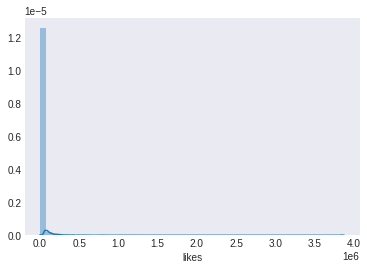

In [10]:
#Since this is a regression problem we view the density plot
sns.distplot(train.likes)

Text(0.5, 1.0, 'Likes Distribution')

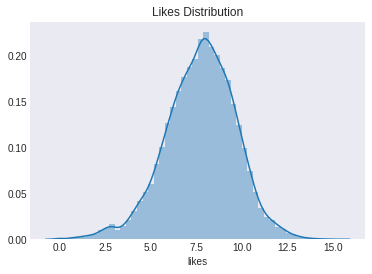

In [11]:
sns.distplot(np.log1p(train.likes))
plt.title("Likes Distribution")

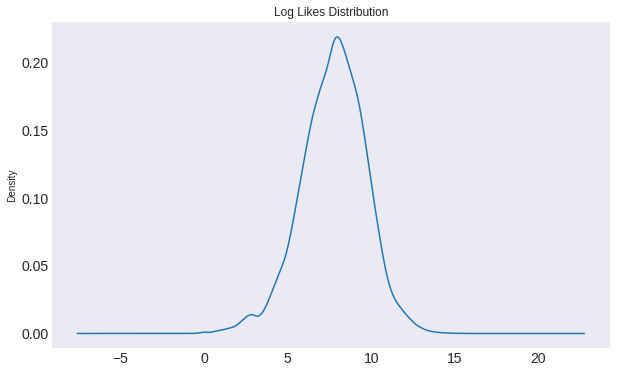

In [12]:
#Just another way to plot
_ = pd.Series(np.log1p(train["likes"])).plot(kind = 'density', title = 'Log Likes Distribution', fontsize=14, figsize=(10, 6))

#### Check Null Values (if present we have to make imputation)

In [13]:
train.isnull().sum()

video_id         0
title            0
channel_title    0
category_id      0
publish_date     0
tags             0
views            0
dislikes         0
comment_count    0
description      0
country_code     0
likes            0
dtype: int64

#### Check how many unique values are present per column

In [14]:
train.nunique()

video_id         26061
title            26005
channel_title     5764
category_id         17
publish_date       348
tags             21462
views            25338
dislikes          2633
comment_count     4993
description      23426
country_code         4
likes            12134
dtype: int64

#### There are 4 types of features that we have:

1. Numerical
2. Categorical
3. Textual
4. DateTime

#### Also our target is Continuous

#### For each feature type we will be perform two types of analysis:

1. Univariate: Analyze 1 feature at a time
2. Bivariate: Analyze the relationship of that feature with target variable, i.e. 'likes'

 ### Numerical Features

In [15]:
numerical_cols = ['views', 'dislikes', 'comment_count']

#### Univariate analysis - Boxplots for outliers snapshot - of train and test data

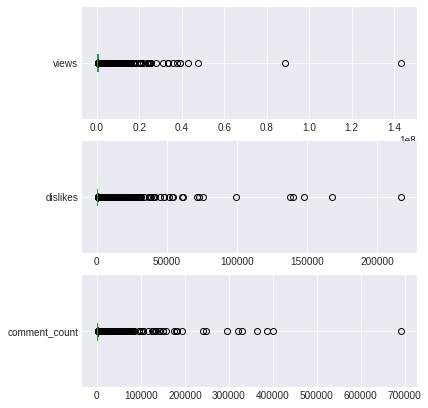

In [16]:
fig, axes = plt.subplots(3, 1, figsize=(6, 7))
for i, c in enumerate(numerical_cols):
  _ = train[[c]].boxplot(ax=axes[i], vert=False)

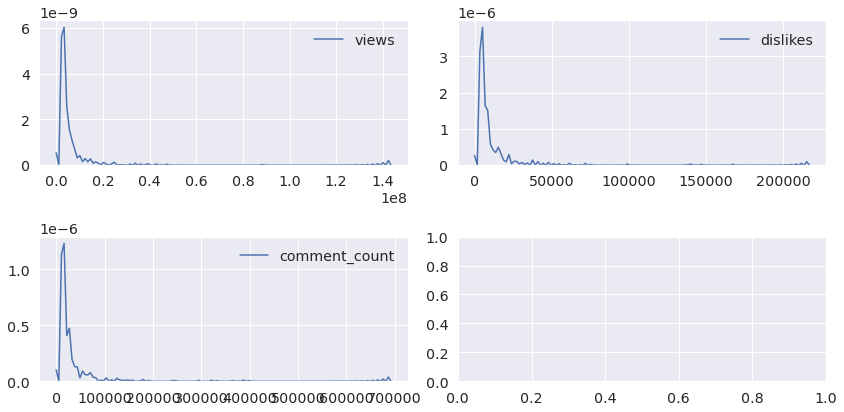

In [17]:
sns.set(font_scale=1.3)
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
axes = [ax for axes_row in axes for ax in axes_row]
for i, c in enumerate(numerical_cols):
    plot = sns.kdeplot(data=train[c], ax=axes[i])
plt.tight_layout()

In [18]:
#We can remove the visible skewed data by log transformations
for c in numerical_cols + ['likes']:
      train[c] = np.log1p(train[c]) 

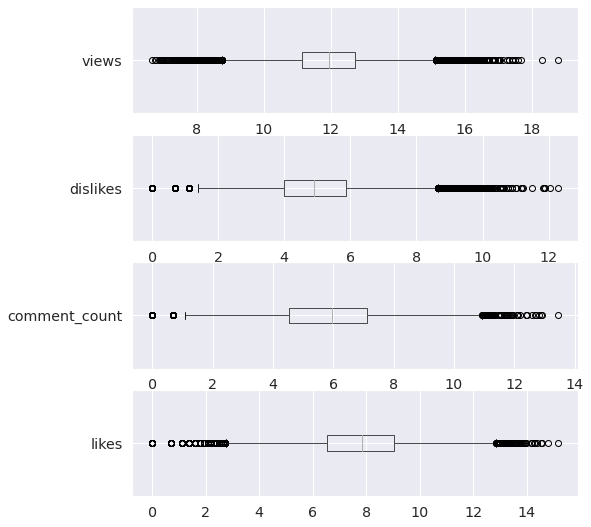

In [19]:
fig, axes = plt.subplots(4, 1, figsize=(8, 9))
for i, c in enumerate(numerical_cols + ['likes']):
    _ = train[[c]].boxplot(ax=axes[i], vert=False)

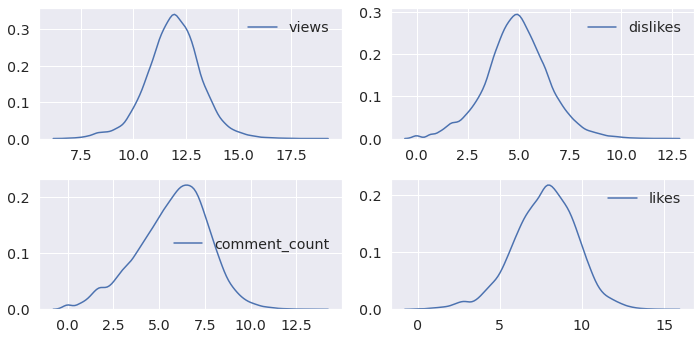

In [20]:
#In above the outliers seem to have decreased after the log transformation

sns.set(font_scale=1.3)
fig, axes = plt.subplots(2, 2, figsize=(10, 5))
axes = [ax for axes_row in axes for ax in axes_row]
for i, c in enumerate(numerical_cols + ['likes']):
    plot = sns.kdeplot(data=train[c], ax=axes[i])
plt.tight_layout()

### Repeating the above steps for test data

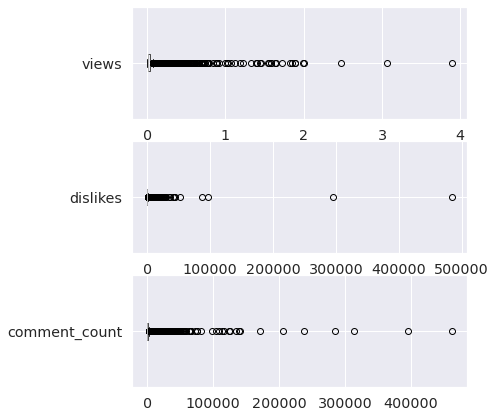

In [21]:
fig, axes = plt.subplots(3, 1, figsize=(6, 7))
for i, c in enumerate(numerical_cols):
  _ = test[[c]].boxplot(ax=axes[i], vert=False)

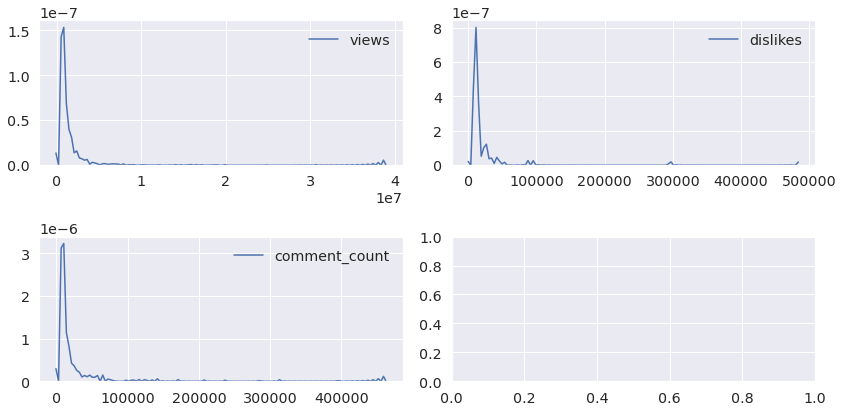

In [22]:
sns.set(font_scale=1.3)
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
axes = [ax for axes_row in axes for ax in axes_row]
for i, c in enumerate(numerical_cols):
    plot = sns.kdeplot(data=test[c], ax=axes[i])
plt.tight_layout()

In [23]:
#We can remove the visible skewed data by log transformations
for c in numerical_cols:
      test[c] = np.log1p(test[c]) 

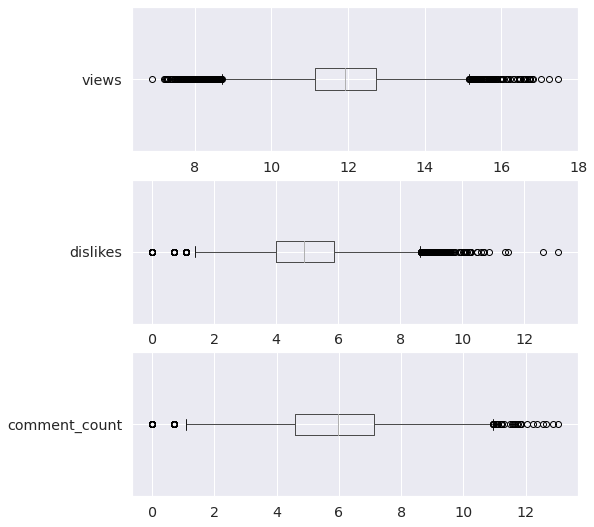

In [24]:
fig, axes = plt.subplots(3, 1, figsize=(8, 9))
for i, c in enumerate(numerical_cols):
    _ = test[[c]].boxplot(ax=axes[i], vert=False)

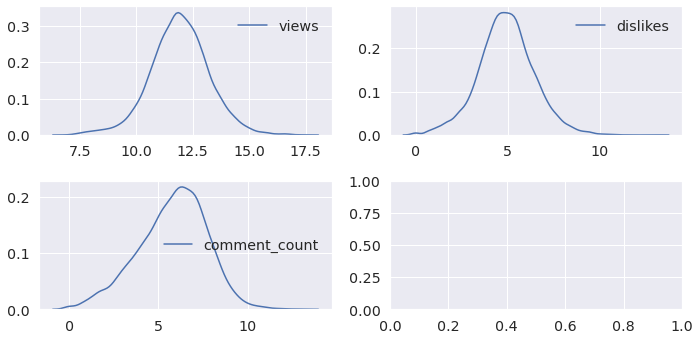

In [25]:
#In above the outliers seem to have decreased after the log transformation

sns.set(font_scale=1.3)
fig, axes = plt.subplots(2, 2, figsize=(10, 5))
axes = [ax for axes_row in axes for ax in axes_row]
for i, c in enumerate(numerical_cols):
    plot = sns.kdeplot(data=test[c], ax=axes[i])
plt.tight_layout()

### Bivariate Analysis

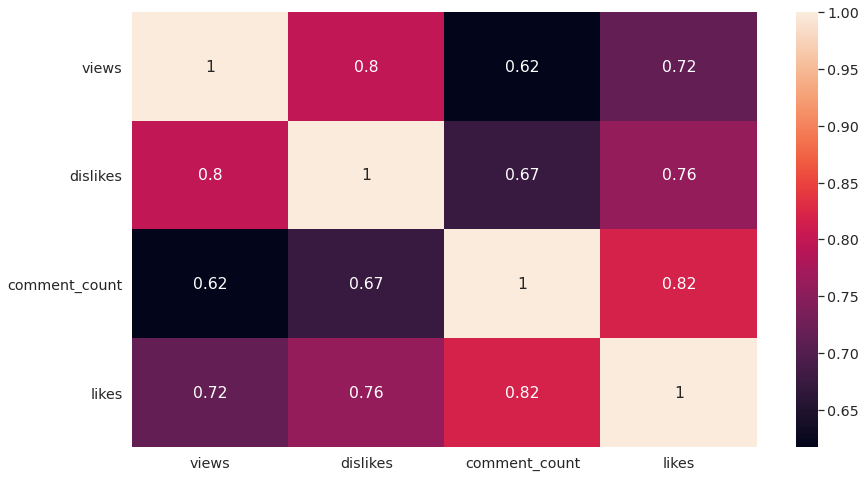

In [26]:
# Corelation heatmaps
plt.figure(figsize=(14, 8))
_ = sns.heatmap(train[numerical_cols + ['likes']].corr(), annot=True)

#### Do videos with more views get more likes ?
- Yes they do, we have a high correlation of 0.72 also the plot between the two variables shows this.

#### Do videos with more comments get more likes ?
- Yes they do, we have a high correlation of 0.82 also the plot between the two variables shows this.

#### Do videos with more dislikes get less likes ?
- Any form of popularity is good popularity. As the number dislikes increases, number of views increases too, and so the number of likes.

#### Do longer videos get more likes than shorter videos ?
- We don't have data to answer this question. Collect more data may be.

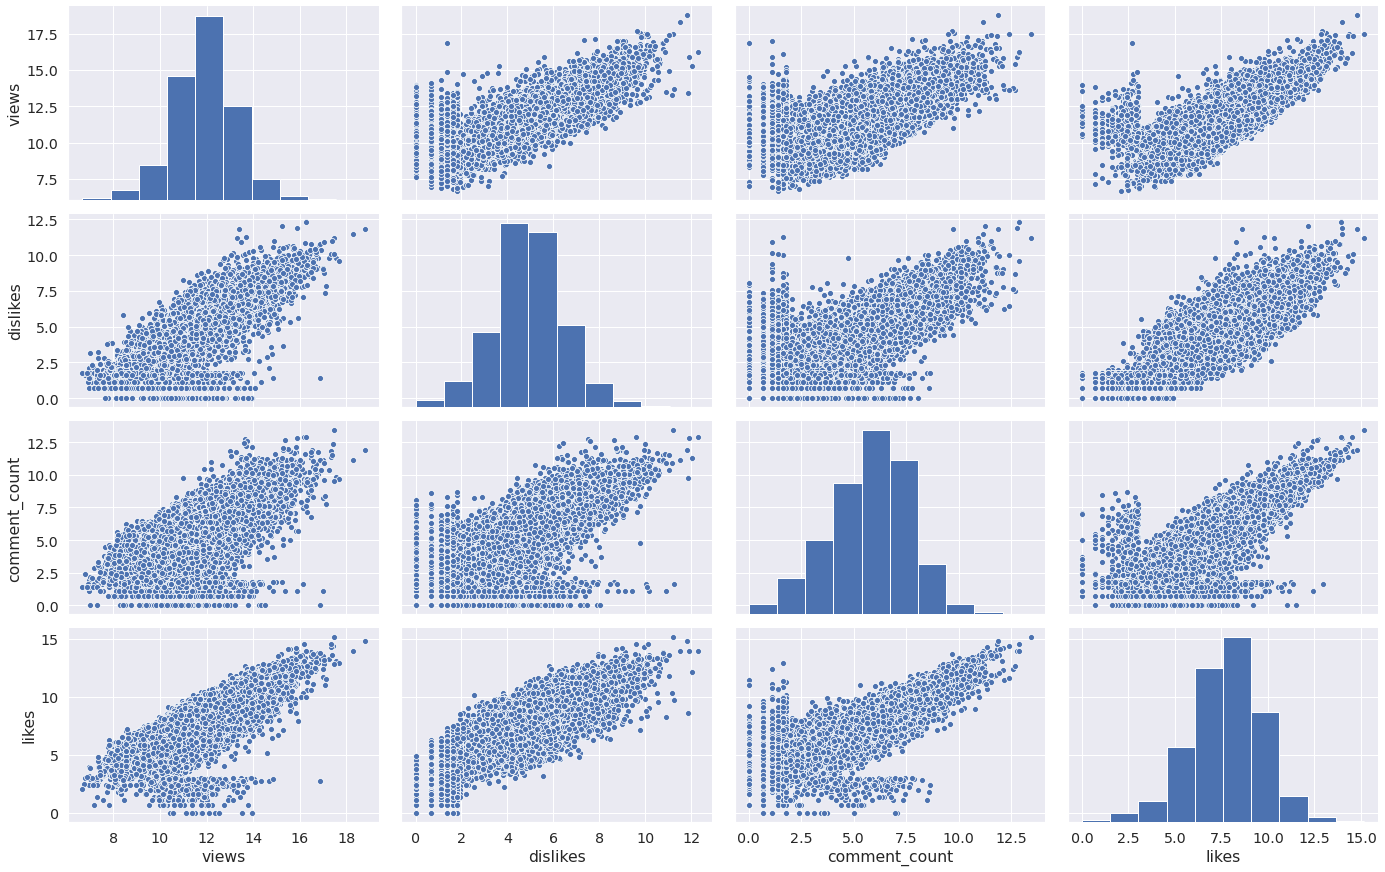

In [27]:
#Pairplots seem to be linear relation among features
_ = sns.pairplot(train[numerical_cols + ['likes']], height=3, aspect=1.6)

### Categorical Features

#### Univariate Analysis (Pie charts)

In [28]:
cat_cols = ['category_id', 'country_code', 'channel_title']
print("No. of unique values in train:")
for c in cat_cols:
    print(c, " =" , len(train[c].unique()))

print("No. of unique values in test:")
for c in cat_cols:
    print(c, " =" , len(test[c].unique()))
    
print(np.sort(train['category_id'].unique()))
print(np.sort(test['category_id'].unique()))

No. of unique values in train:
category_id  = 17
country_code  = 4
channel_title  = 5764
No. of unique values in test:
category_id  = 16
country_code  = 4
channel_title  = 3598
[ 1.  2. 10. 15. 17. 19. 20. 22. 23. 24. 25. 26. 27. 28. 29. 30. 43.]
[ 1.  2. 10. 15. 17. 19. 20. 22. 23. 24. 25. 26. 27. 28. 29. 43.]


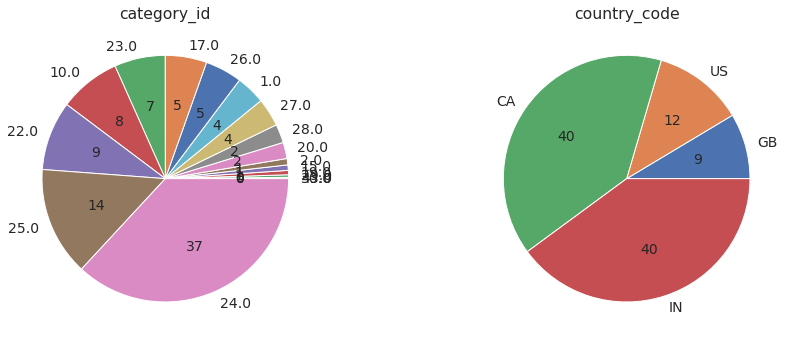

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for i, c in enumerate(['category_id', 'country_code']):
    _ = train[c].value_counts()[::-1].plot(kind = 'pie', ax=axes[i], title=c, autopct='%.0f', fontsize=14)
    _ = axes[i].set_ylabel('')
    
_ = plt.tight_layout()

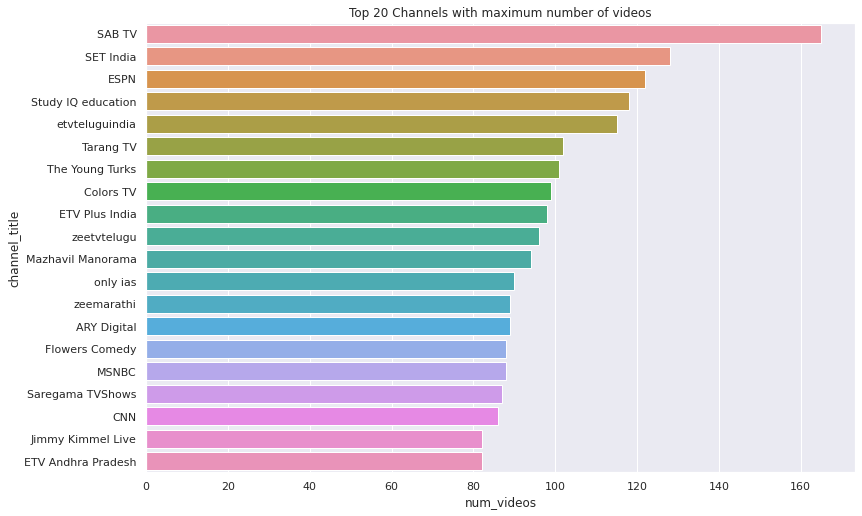

In [30]:
#Top 20 channels in train dataset
sns.set(rc={'figure.figsize':(12.7, 8.27)})

top_20_channels = train['channel_title'].value_counts()[:20].reset_index()
top_20_channels.columns = ['channel_title', 'num_videos']

_ = sns.barplot(data = top_20_channels, y = 'channel_title', x = 'num_videos')
_ = plt.title("Top 20 Channels with maximum number of videos")

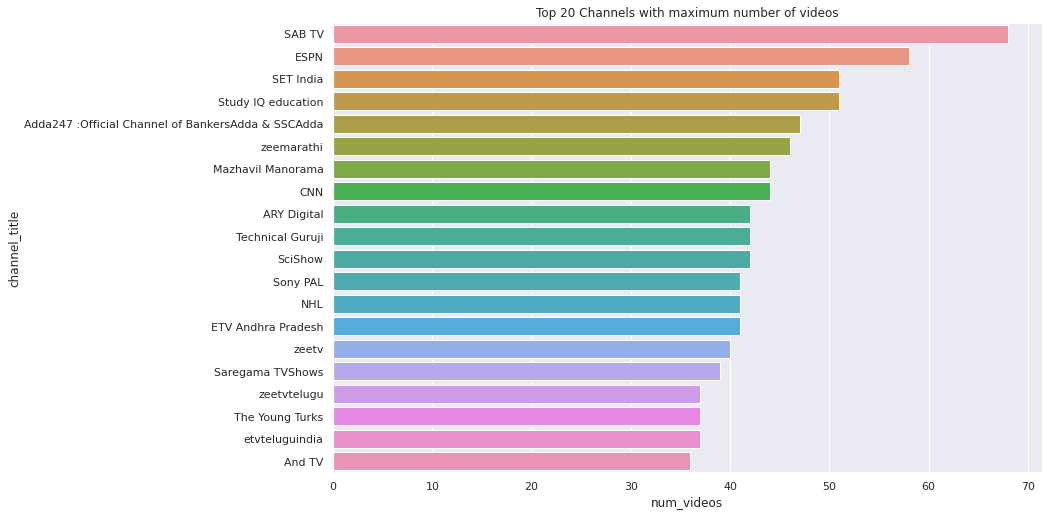

In [31]:
#Top 20 channels in test dataset
sns.set(rc={'figure.figsize':(12.7, 8.27)})

top_20_channels_t = test['channel_title'].value_counts()[:20].reset_index()
top_20_channels_t.columns = ['channel_title', 'num_videos']

_ = sns.barplot(data = top_20_channels_t, y = 'channel_title', x = 'num_videos')
_ = plt.title("Top 20 Channels with maximum number of videos")

In [32]:
#Common channels in top 20 - train and test -ALL common
l = np.sort(top_20_channels.channel_title.tolist())
print(l)
ll = np.sort(top_20_channels_t.channel_title.tolist())
print(ll)
len([value for value in l if value in ll] )

['ARY Digital' 'CNN' 'Colors TV' 'ESPN' 'ETV Andhra Pradesh'
 'ETV Plus India' 'Flowers Comedy' 'Jimmy Kimmel Live' 'MSNBC'
 'Mazhavil Manorama' 'SAB TV' 'SET India' 'Saregama TVShows'
 'Study IQ education' 'Tarang TV' 'The Young Turks' 'etvteluguindia'
 'only ias' 'zeemarathi' 'zeetvtelugu']
['ARY Digital' 'Adda247 :Official Channel of BankersAdda & SSCAdda'
 'And TV' 'CNN' 'ESPN' 'ETV Andhra Pradesh' 'Mazhavil Manorama' 'NHL'
 'SAB TV' 'SET India' 'Saregama TVShows' 'SciShow' 'Sony PAL'
 'Study IQ education' 'Technical Guruji' 'The Young Turks'
 'etvteluguindia' 'zeemarathi' 'zeetv' 'zeetvtelugu']


13

### Bivariate Analysis

*Country Wise Number of Videos for Channel*

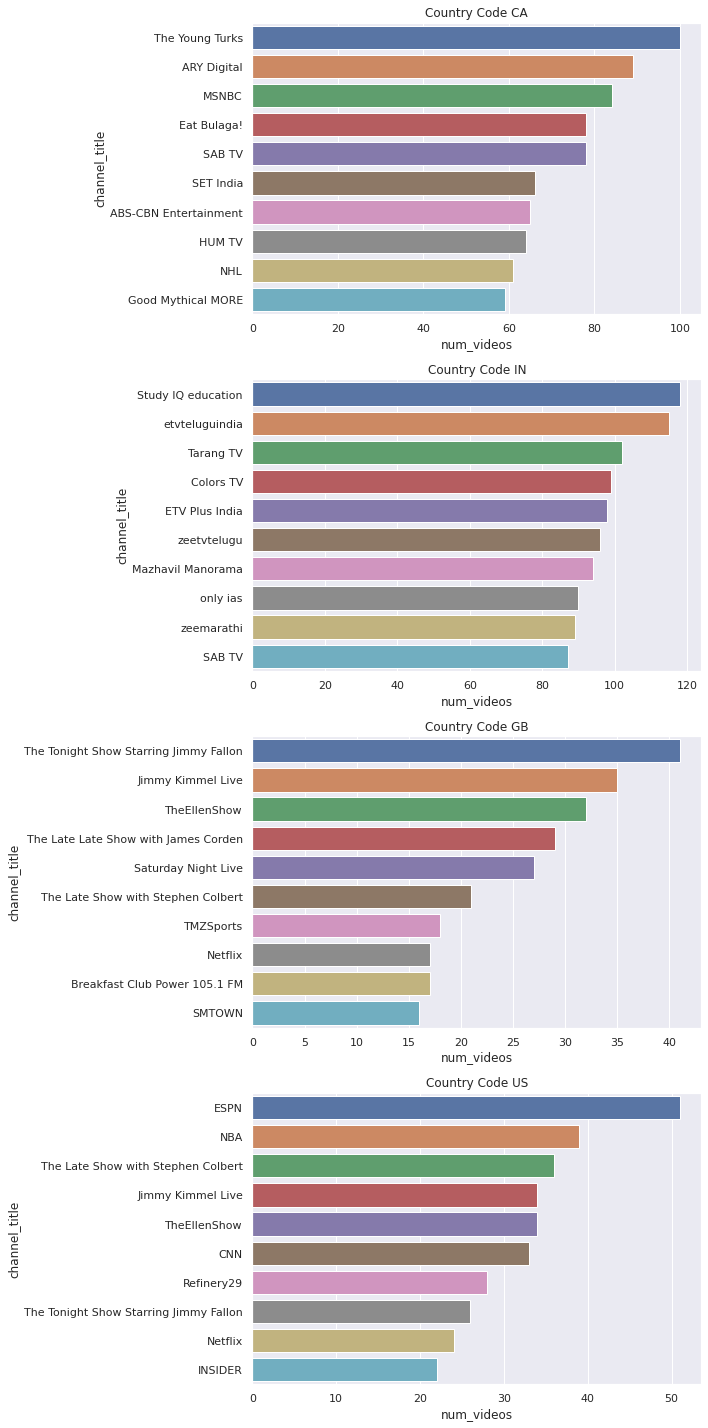

In [33]:
country_wise_channels = train.groupby(['country_code', 'channel_title']).size().reset_index()
country_wise_channels.columns = ['country_code', 'channel_title', 'num_videos']
country_wise_channels = country_wise_channels.sort_values(by = 'num_videos', ascending=False)

fig, axes = plt.subplots(4, 1, figsize=(10, 20))

for i, c in enumerate(train['country_code'].unique()):
  country = country_wise_channels[country_wise_channels['country_code'] == c][:10]
  _ = sns.barplot(x = 'num_videos', y = 'channel_title', data = country, ax = axes[i])
  _ = axes[i].set_title(f'Country Code {c}')

plt.tight_layout()

### Multivariate Analysis

#### Country-wise likes for channel

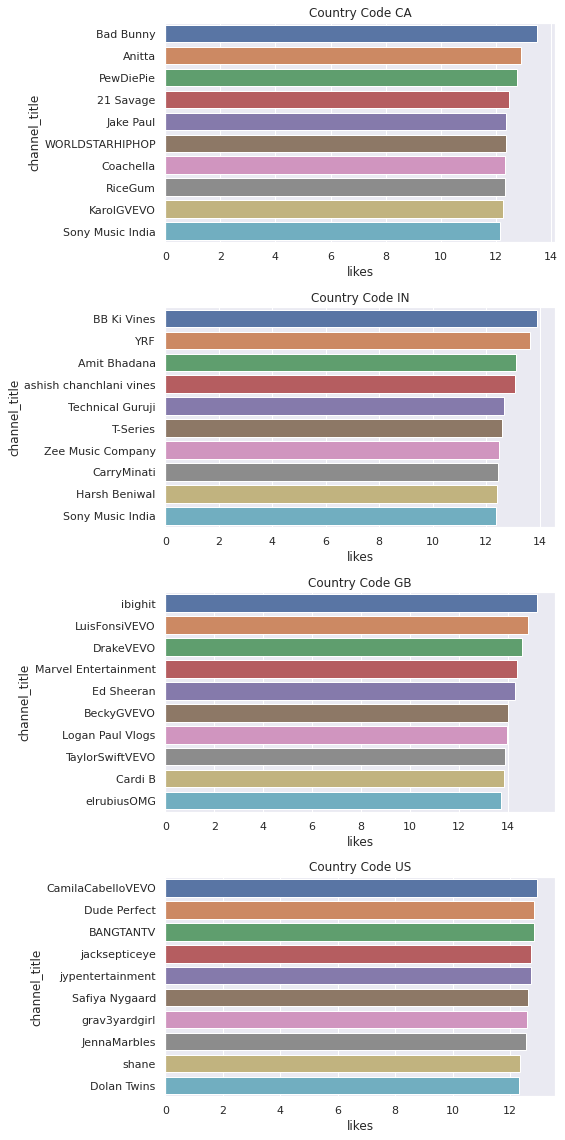

In [34]:
country_wise_channels = train.groupby(['country_code', 'channel_title'])['likes'].max().reset_index()
country_wise_channels = country_wise_channels.sort_values(by = ['likes'], ascending=False)

fig, axes = plt.subplots(4, 1, figsize=(8, 16))

for i, c in enumerate(train['country_code'].unique()):
  country = country_wise_channels[country_wise_channels['country_code'] == c][:10]
  _ = sns.barplot(x = 'likes', y = 'channel_title', data = country, ax = axes[i])
  _ = axes[i].set_title(f'Country Code {c}')

plt.tight_layout()

#### Country-wise Likes Distribution

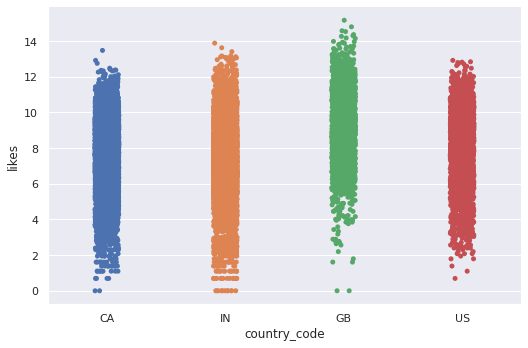

In [35]:
_ = sns.catplot(x="country_code", y="likes", data=train, height=5, aspect=1.5)

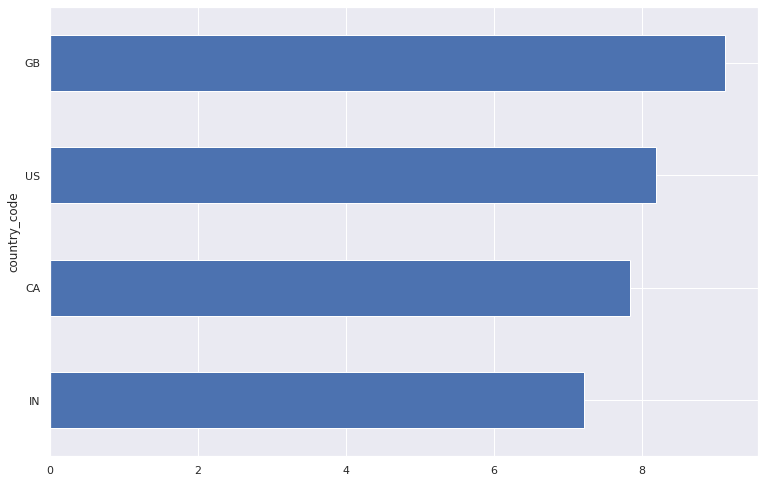

In [36]:
#Mean likes per country
_ = train.groupby('country_code')['likes'].mean().sort_values().plot(kind = 'barh')

#### Category-wise Likes distribution

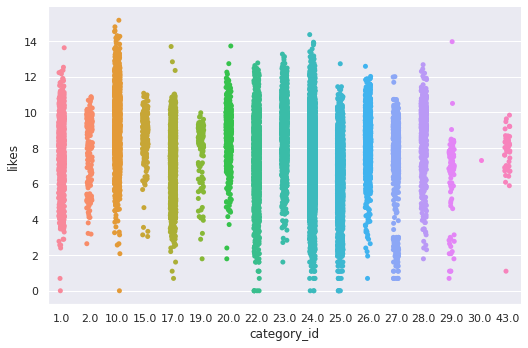

In [37]:
_ = sns.catplot(x="category_id", y="likes", data=train, height=5, aspect=1.5)

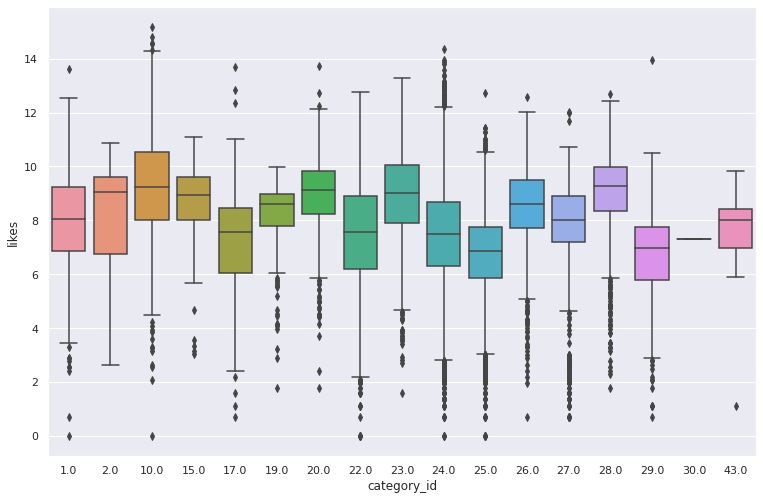

In [38]:
_ = sns.boxplot(x="category_id", y="likes", data=train)

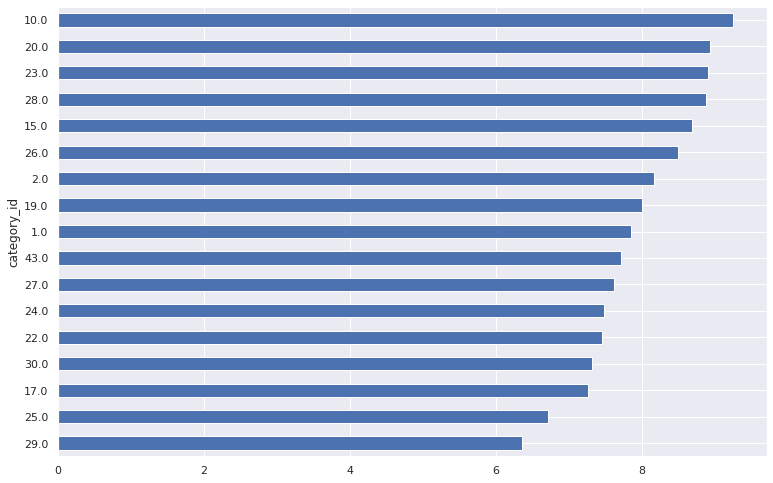

In [39]:
#Mean likes per category
_ = train.groupby('category_id')['likes'].mean().sort_values().plot(kind = 'barh')

### DateTime Variables

In [40]:
train['publish_date'] = pd.to_datetime(train['publish_date'], format='%Y-%m-%d')
test['publish_date'] = pd.to_datetime(test['publish_date'], format='%Y-%m-%d')
train['publish_date']

0       2017-12-12
1       2018-03-08
2       2018-03-26
3       2018-02-21
4       2018-05-10
           ...    
26056   2018-01-16
26057   2017-12-17
26058   2018-03-04
26059   2018-05-17
26060   2018-01-16
Name: publish_date, Length: 26061, dtype: datetime64[ns]

In [41]:
#Value Counts of Videos Year Wise
train['publish_date'].dt.year.value_counts()

2018    18841
2017     7132
2015       16
2016       16
2011       13
2014        9
2013        9
2009        8
2012        6
2010        4
2008        3
2007        3
2006        1
Name: publish_date, dtype: int64

### Date wise number of videos in train and test data

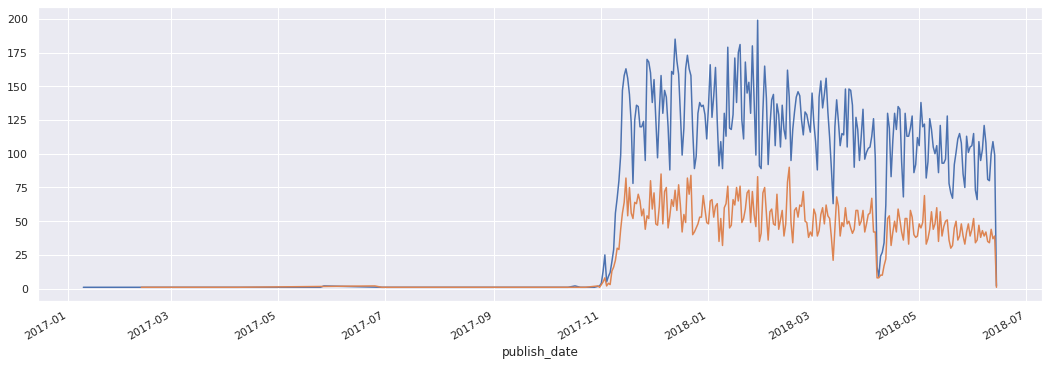

In [42]:
latest_data_train = train[train['publish_date'] > '2017']
latest_data_test = test[test['publish_date'] > '2017']
_ = latest_data_train.sort_values(by = 'publish_date').groupby('publish_date').size().plot(figsize=(18, 6))
_ = latest_data_test.sort_values(by = 'publish_date').groupby('publish_date').size().plot(figsize=(18, 6))

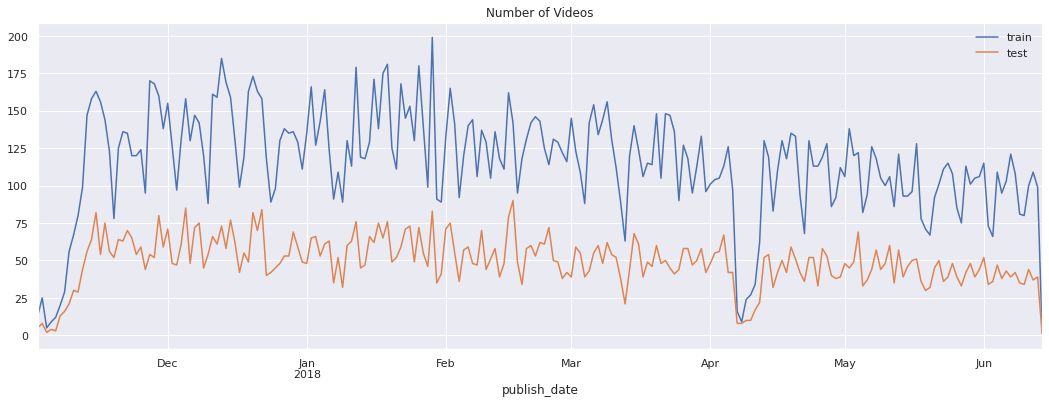

In [44]:
#Closer look
latest_data_train = train[train['publish_date'] > '2017-11']
latest_data_test = test[test['publish_date'] > '2017-11']
_ = latest_data_train.sort_values(by = 'publish_date').groupby('publish_date').size().rename('train').plot(figsize=(18, 6), title = 'Number of Videos')
_ = latest_data_test.sort_values(by = 'publish_date').groupby('publish_date').size().rename('test').plot(figsize=(18, 6), title = 'Number of Videos')
_ = plt.legend()

#### Seems similar distribution. No stark difference in train and test video frequencies in the time period. 

### Mean Likes vs Publish Date

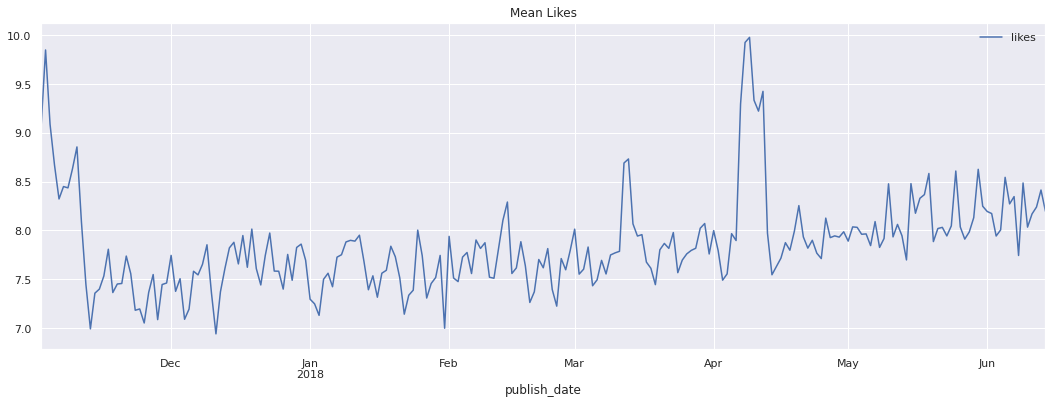

In [46]:
latest_data = train[train['publish_date'] > '2017-11']
_ = latest_data.sort_values(by = 'publish_date').groupby('publish_date')['likes'].mean().plot(figsize=(18, 6), title="Mean Likes")
_ = plt.legend()

### Number of videos by Country

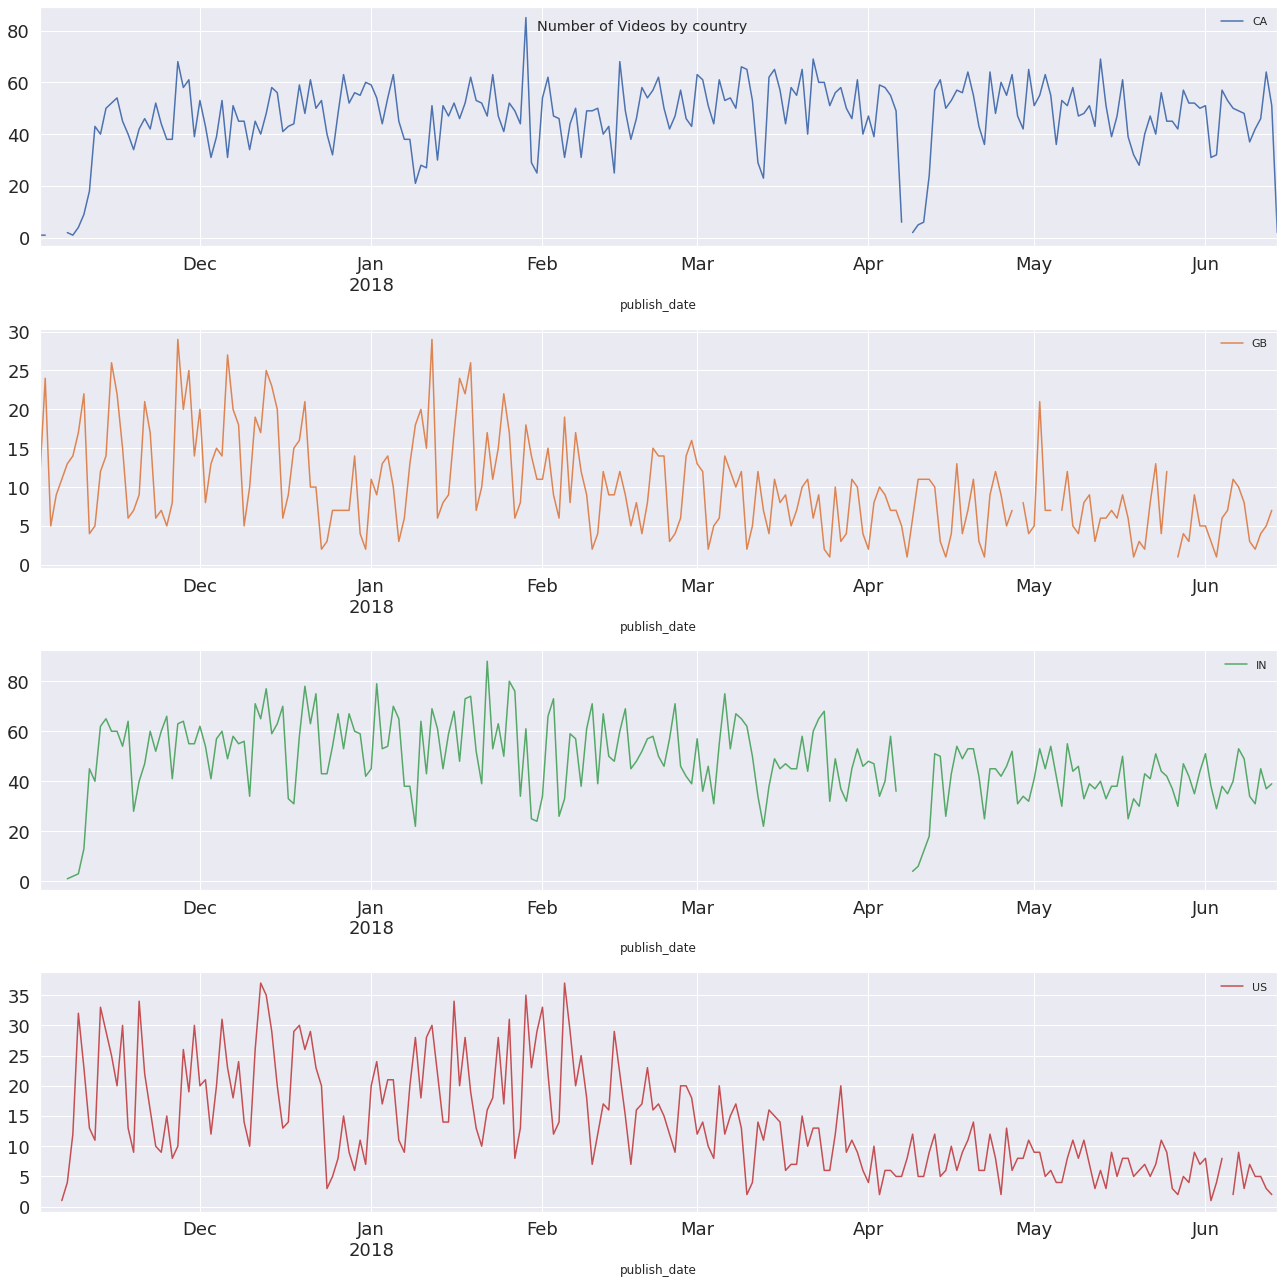

In [47]:
tmp = latest_data.groupby(['publish_date', 'country_code']).size().reset_index()
_ = tmp.pivot_table(index = 'publish_date', columns = 'country_code', values=0).plot(subplots=True, figsize=(18, 18),
                                                                                           title='Number of Videos by country',
                                                                                           sharex=False,
                                                                                           fontsize=18)
plt.tight_layout()

### Country-wise Mean number of likes vs Publish Date

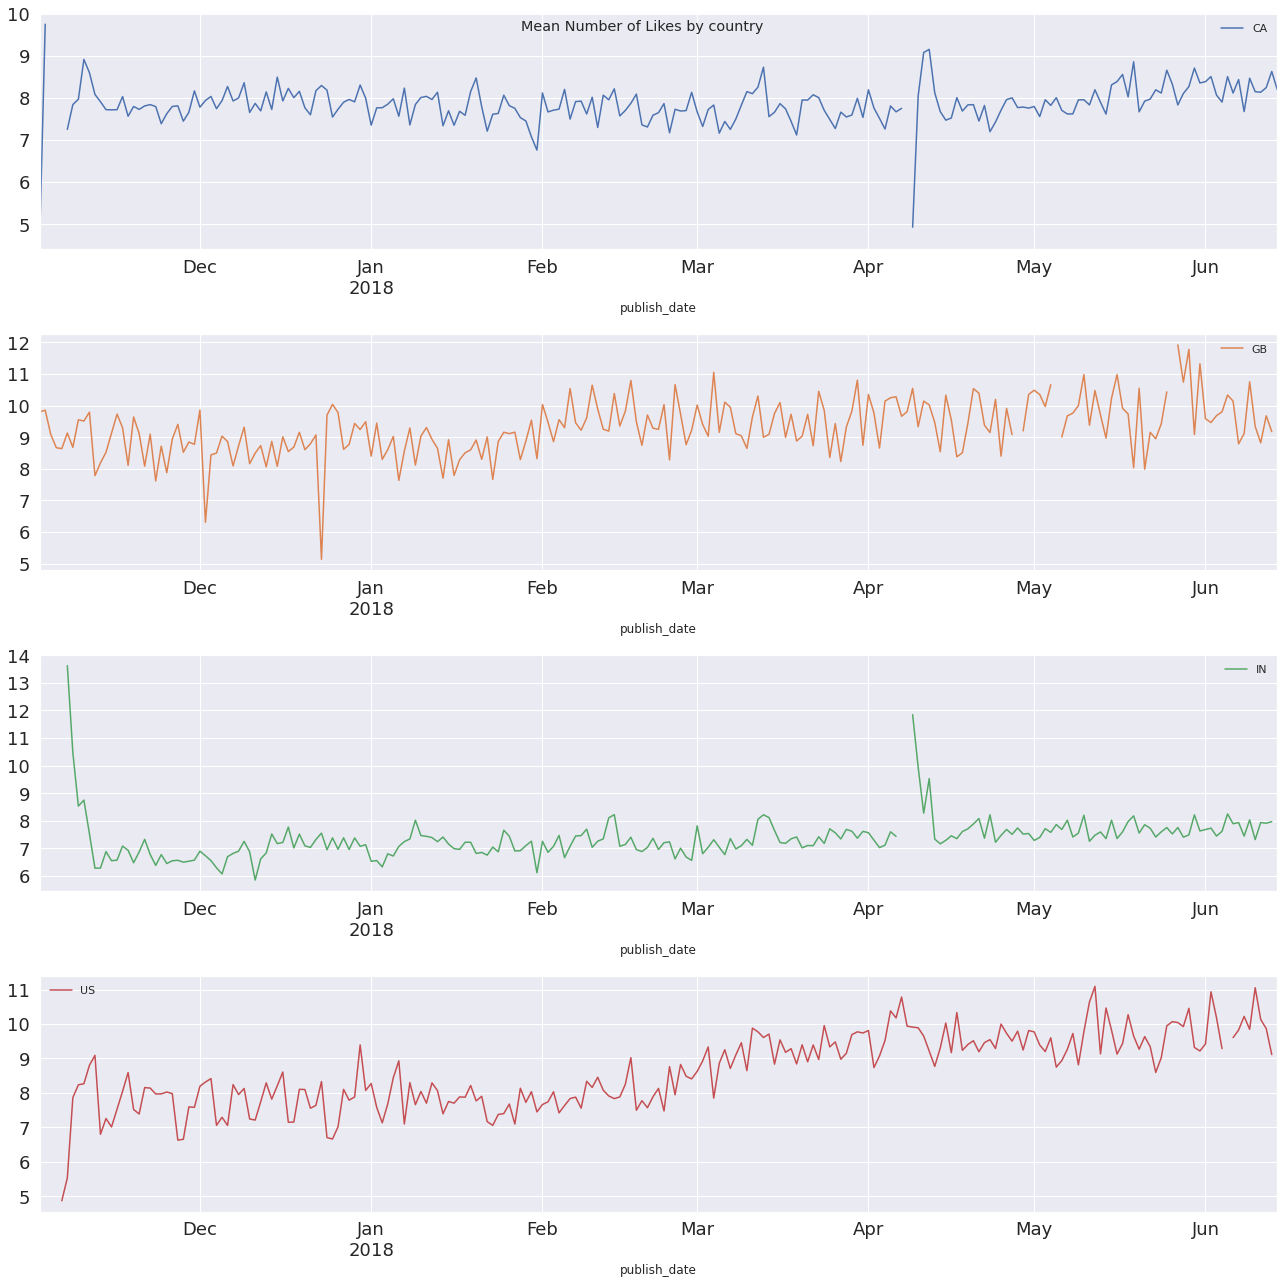

In [48]:
tmp = latest_data.groupby(['publish_date', 'country_code'])['likes'].mean().reset_index()
_ = tmp.pivot_table(index = 'publish_date', columns = 'country_code', values='likes').plot(subplots=True, figsize=(18, 18),
                                                                                           title='Mean Number of Likes by country',
                                                                                           sharex=False,
                                                                                           fontsize=18)
plt.tight_layout()

### Do people post more videos on weekends than weekdays ?

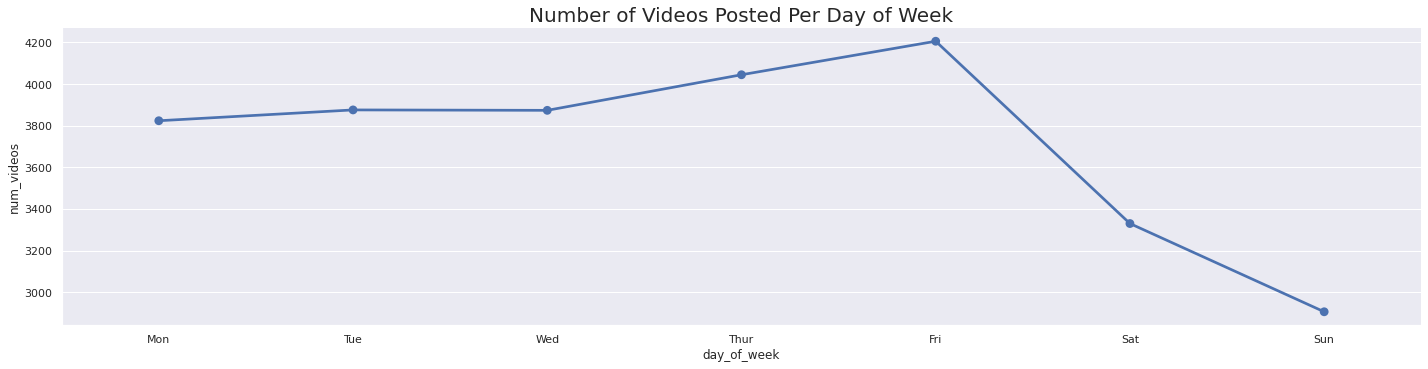

In [49]:
train['dayofweek'] = train['publish_date'].dt.dayofweek
n_videos_per_day_of_week = train['dayofweek'].value_counts().sort_index().reset_index()
n_videos_per_day_of_week.columns = ['day_of_week', 'num_videos']
n_videos_per_day_of_week['day_of_week'] = ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']
_ = sns.catplot(x = 'day_of_week', y = 'num_videos', data = n_videos_per_day_of_week, kind = 'point',aspect = 24/6)
_ = plt.title("Number of Videos Posted Per Day of Week", fontsize=20)

#### It looks our hypothesis is incorrect in context of the current data. Most of the videos were published on Friday, but Saturday and Sunday saw the least number of videos published

## Textual Data (Word Clouds)

In [51]:
text_cols = ['title', 'tags', 'description']

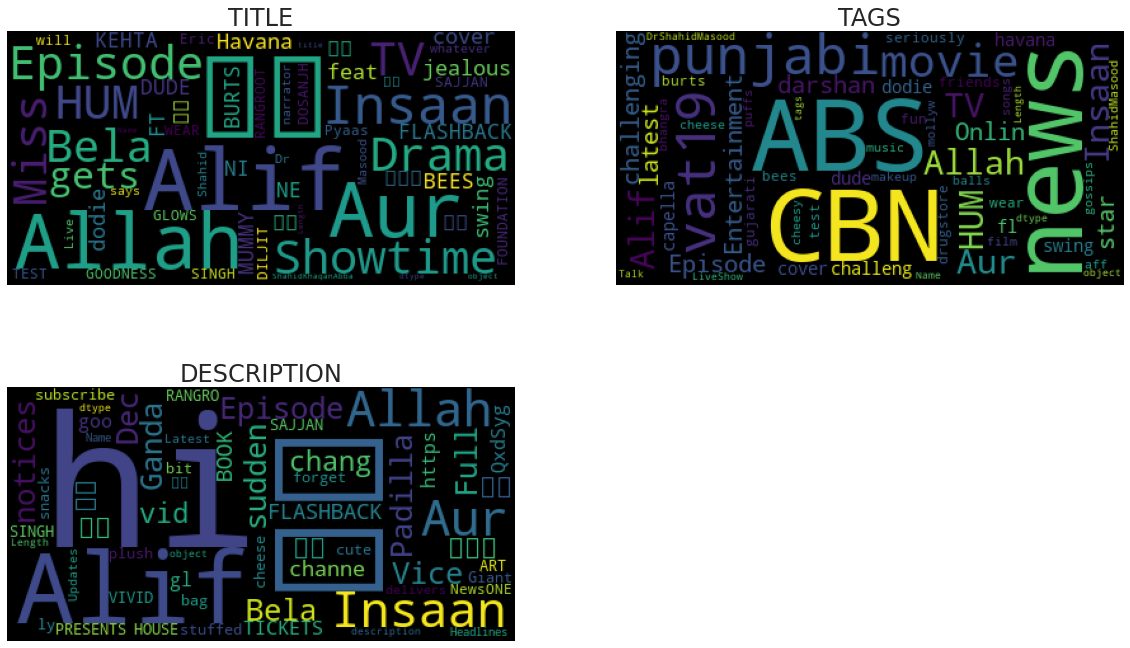

In [52]:
from wordcloud import WordCloud, STOPWORDS

wc = WordCloud(stopwords = set(list(STOPWORDS) + ['|']), random_state = 42)
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
axes = [ax for axes_row in axes for ax in axes_row]

for i, c in enumerate(text_cols):
  op = wc.generate(str(train[c]))
  _ = axes[i].imshow(op)
  _ = axes[i].set_title(c.upper(), fontsize=24)
  _ = axes[i].axis('off')

_ = fig.delaxes(axes[3])

In [53]:
train['likes'].describe()

count    26061.000000
mean         7.739954
std          1.927899
min          0.000000
25%          6.527958
50%          7.840706
75%          9.054154
max         15.171369
Name: likes, dtype: float64

In [54]:
def plot_countrywise(country_code = 'IN'):
  country = train[train['country_code'] == country_code]
  country = country[country['likes'] > 10]
  fig, axes = plt.subplots(2, 2, figsize=(20, 12))
  axes = [ax for axes_row in axes for ax in axes_row]

  for i, c in enumerate(text_cols):
    op = wc.generate(str(country[c]))
    _ = axes[i].imshow(op)
    _ = axes[i].set_title(c.upper(), fontsize=24)
    _ = axes[i].axis('off')

  fig.delaxes(axes[3])
  _ = plt.suptitle(f"Country Code: '{country_code}'", fontsize=30)

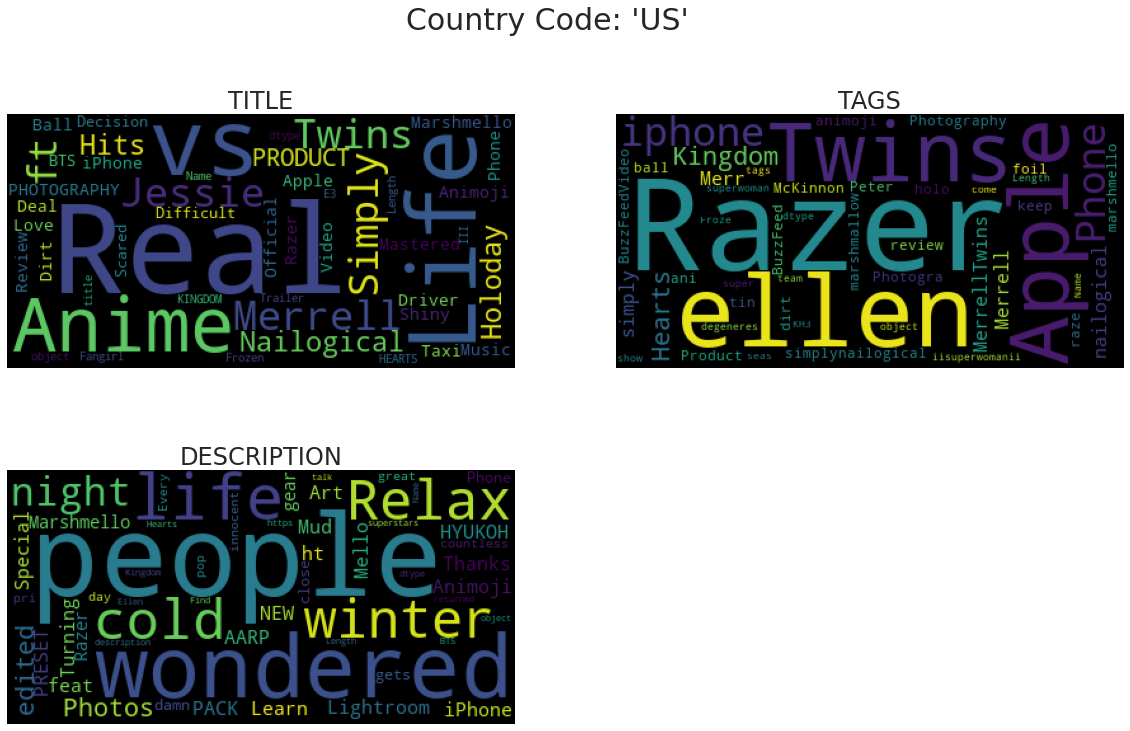

In [55]:
plot_countrywise("US")

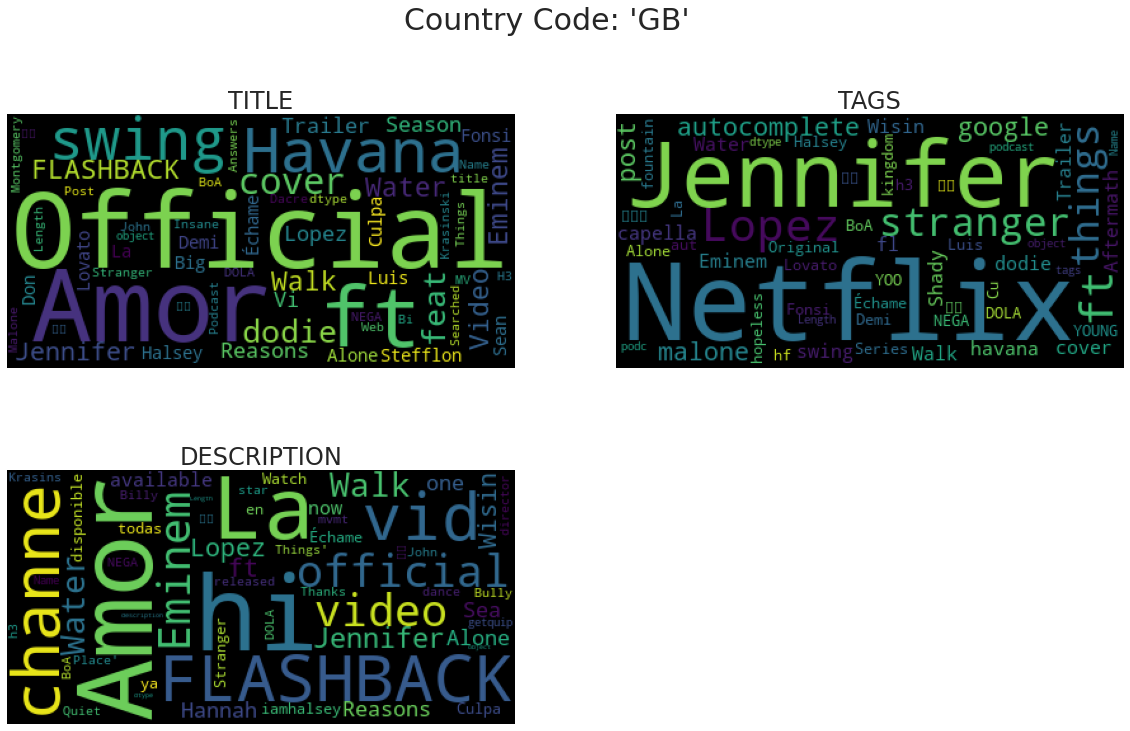

In [56]:
plot_countrywise("GB")

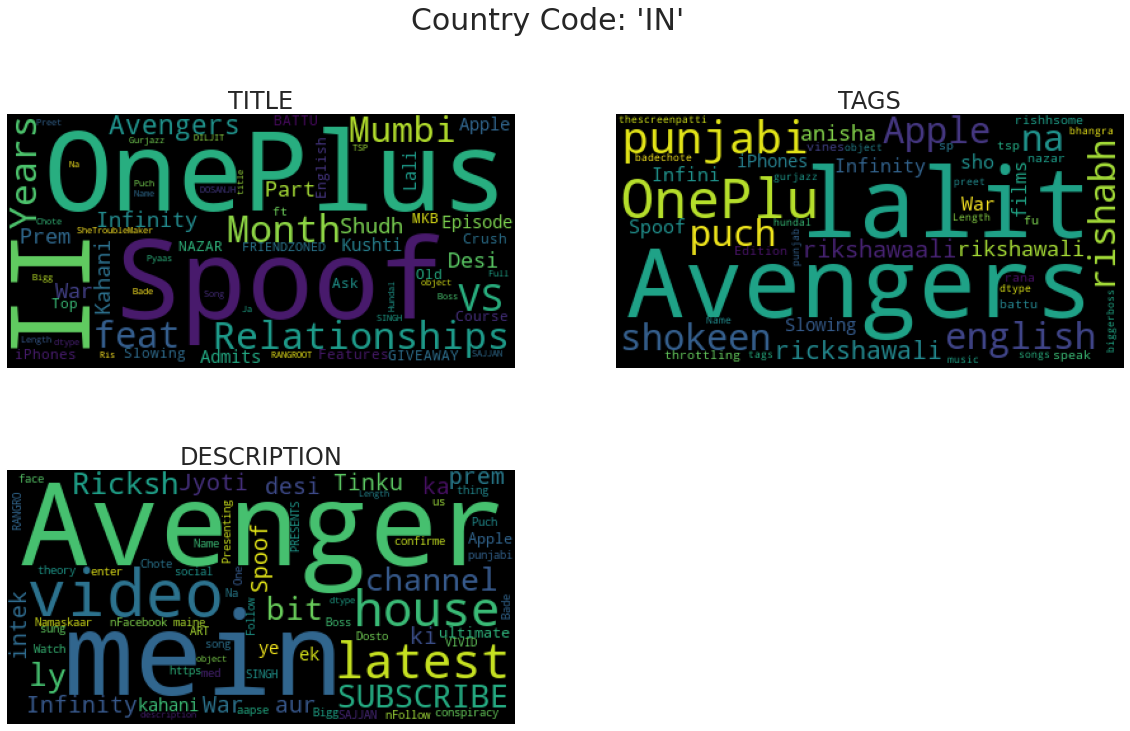

In [57]:
plot_countrywise("IN")

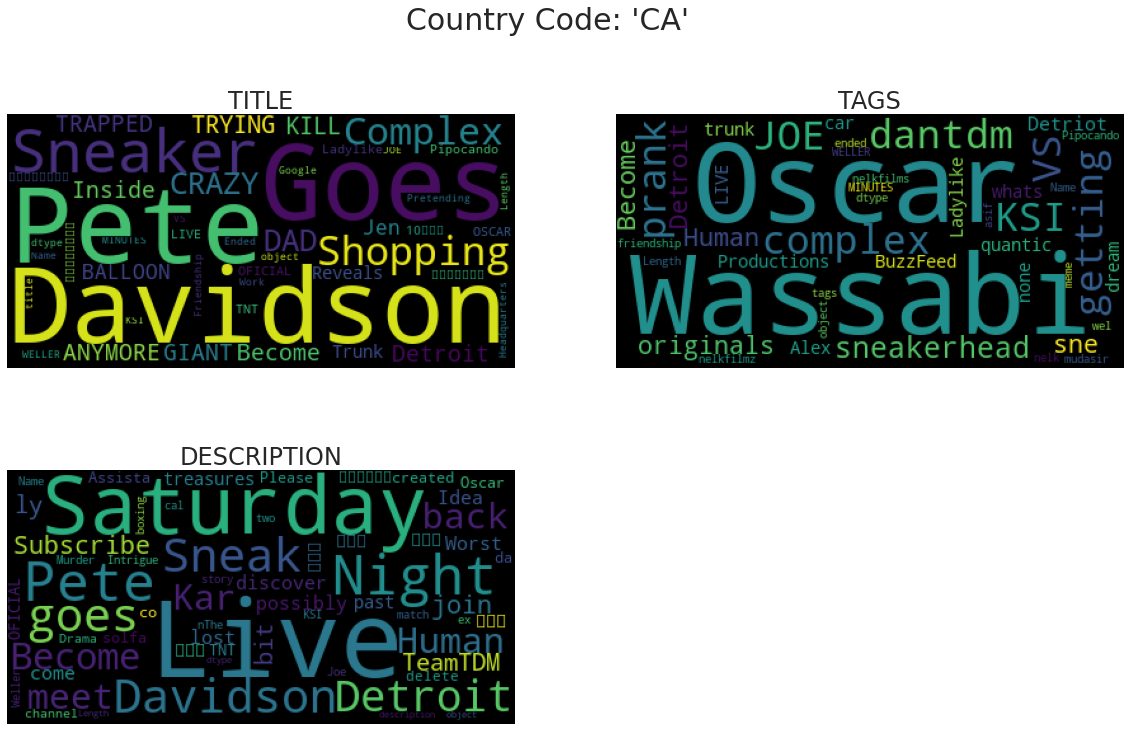

In [58]:
plot_countrywise("CA")

### Do descriptive videos get more number of likes ?

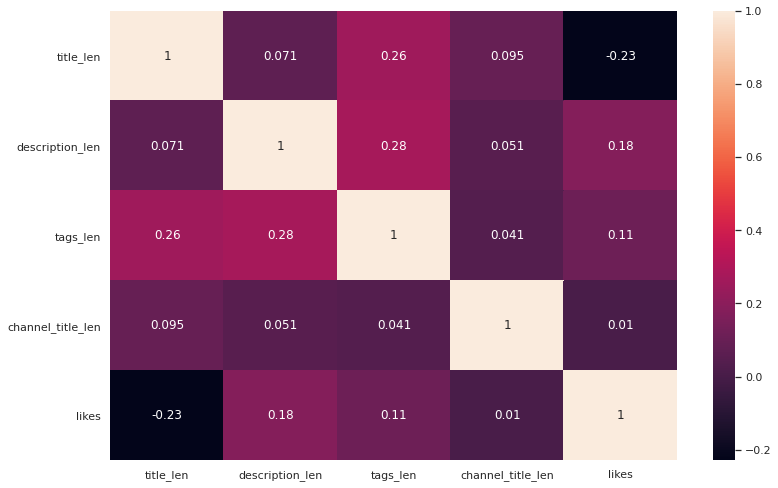

In [59]:
train['title_len'] = train['title'].apply(lambda x: len(x))
train['description_len'] = train['description'].apply(lambda x: len(x))
train['tags_len'] = train['tags'].apply(lambda x: len(x))
train['channel_title_len'] = train['channel_title'].apply(lambda x: len(x))

_  = sns.heatmap(train[['title_len', 'description_len', 'tags_len', 'channel_title_len', 'likes']].corr(), annot = True)

#### So if you keep your title length short and description long, you are having higher chances of getting likes. Since correlation score is 0.18 which is very poor.

## Baseline Models

#### METRIC
#### RMSLE(Root Mean Squared Log Error)
#### *Simply put RMSLE is the Root Mean Squared Error of the logarithm of actual and predicted values.* The Robustness of RMSLE to the outliers, the property of calculating the relative error between the Predicted and Actual Values, the most unique property of the RMLSE that it penalizes the underestimation of the actual value more severely than it does for the Overestimation.

In [60]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error

def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

def av_metric(y_true, y_pred):
    return 1000 * np.sqrt(mean_squared_error(y_true, y_pred))

target = train['likes']

### Model 1 : Predicting all instances as mean of target

In [61]:
preds_target = pd.Series([target.mean()] * len(train))
av_metric_score = av_metric(target, preds_target)
print(f'AV metric score is: {av_metric_score}')

AV metric score is: 1927.8618309979083


### But above we had already done log transformation for the 'likes' in train dataset. We need to undo this transformation, for submission. So the preds_target in above cell is the log transformed value.
To have the actual scale of the target we need to do exp of the preds_target

In [62]:
preds_test = pd.Series([target.mean()] * len(test))
preds_test = np.expm1(preds_test)

In [78]:
cd /kaggle/working

/kaggle/working


In [79]:
def submit(preds_test, name):
    test['preds_test'] = preds_test
    submission = test[['video_id','preds_test']]
    print(submission.head())
    submission.to_excel(name+'.xlsx')
submit(preds_test, 'Mean_target')

   video_id  preds_test
0     87185  2297.36779
1      9431  2297.36779
2     40599  2297.36779
3       494  2297.36779
4     73942  2297.36779


### Model 2 : Predicting all instances as median of target

In [80]:
preds_target = pd.Series([target.median()] * len(train))

av_metric_score = av_metric(target, preds_target)

print(f'AV metric score is: {av_metric_score}')
preds_test = pd.Series([target.median()] * len(test))
preds_test = np.expm1(preds_test)
submit(preds_test, 'Median_target')

AV metric score is: 1930.4927341163989
   video_id  preds_test
0     87185      2541.0
1      9431      2541.0
2     40599      2541.0
3       494      2541.0
4     73942      2541.0


### Model 3: (Predicting using number of views)

In [82]:
likes_per_view = ((train['likes'] + 1)/(train['views'] + 1)) # one added to avoid divide by zero error
likes_per_view.mean()

0.6723608458619709

In [83]:
preds_target = train['views'] * 0.677

av_metric_score = av_metric(target, preds_target)

print(f'AV metric score is: {av_metric_score}')
preds_test = test['views'] * 0.672
preds_test = np.expm1(preds_test)
submit(preds_test, 'Num_of_views_target')

AV metric score is: 1473.9157749667168
   video_id   preds_test
0     87185  1983.992005
1      9431  3011.668763
2     40599   366.210328
3       494  2127.936090
4     73942  1504.223504


The loss has gone down. so makes sense.

### Model 4: (Predicting using number of comments)

In [84]:
likes_per_comment = (train['likes'] + 1)/(train['comment_count'] + 1)
likes_per_comment.mean()

1.370729312306306

In [85]:
preds_target = train['comment_count'] * 1.37

av_metric_score = av_metric(target, preds_target)

print(f'AV metric score is: {av_metric_score}')
preds_test = test['comment_count'] * 1.37
preds_test = np.expm1(preds_test)
submit(preds_test, 'Num_of_comments_target')

AV metric score is: 1549.204914717152
   video_id   preds_test
0     87185   403.793269
1      9431  2611.111997
2     40599    16.267652
3       494  2761.359541
4     73942   991.895146


### Model 5: (Predicting using number of dislikes)

In [86]:
likes_per_dislike = (train['likes'] + 1)/(train['dislikes']+1)
likes_per_dislike.mean()

1.523152073084116

In [ ]:
preds_target = train['dislikes'] * 1.52

av_metric_score = av_metric(target, preds_target)

print(f'AV metric score is: {av_metric_score}')
preds_test = test['dislikes'] * 1.52
preds_test = np.expm1(preds_test)
submit(preds_test, 'Num_of_dislikes_target')